In [293]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import re
import string
import scipy.spatial.distance as ds
from sklearn.feature_extraction.text import HashingVectorizer
from tqdm import tqdm

In [140]:
# Data path
main_path = 'C:\\Users\\MyPC\\Desktop\\vs py\\Innowise HW\\1. Data\\'

In [294]:
# Additional functions

def get_files_list(main_path):
    
    files_dict = {}
    files_list = os.listdir(main_path)
    
    for file in files_list:
        file_name = file.split('.csv')[0]
        files_dict[file_name] = file
        
    print(files_dict)   
    return files_dict

def get_df(path):
    
    df_path = os.path.join(main_path, path)
    df = pd.read_csv(df_path)
    
    return df


def get_unnique_counts(column_name, df):
    
    united_df = pd.DataFrame({column_name: [], 'Count': []})
    unique_counts = df[column_name].value_counts()
    united_df[column_name] =  pd.unique(df[column_name])

    for i in range(len(united_df[column_name])):
        united_df['Count'].iloc[i] = unique_counts[united_df[column_name].iloc[i]]
        
    return united_df


def str_to_date(str_time):
    
    date_str = str_time
    date_format = '%Y-%m-%d'
    date_obj = datetime.strptime(date_str, date_format).date()
    
    return date_obj


def middle_of_month(pd_series):
    
    month_number = pd_series[0]
    
    splited_date = sales_train_df[sales_train_df['date_block_num'] == month_number]['date'].max().split('.')
    begin_of_month = int(sales_train_df[sales_train_df['date_block_num'] == month_number]['date'].min().split('.')[0])
    end_of_month = int(sales_train_df[sales_train_df['date_block_num'] == month_number]['date'].max().split('.')[0])
    middle_day = int((end_of_month - begin_of_month) / 2)
    
    splited_date[0] = middle_day
    splited_date = '-'.join(map(str, splited_date[::-1]))
    pd_series[0] = splited_date
    
    return pd_series

# Change months numbers to dd.mm.yyyy
def prepare_time_series(df, colum):
    
    for i in range(len(df)):
        df.iloc[i] = middle_of_month(df.iloc[i])

    df.set_index(colum, inplace = True)
    df.index = pd.to_datetime(df.index)
    
    return df

def symbol_filter(record):
    
    power_numbers = ['⁰', '¹', '²', '³', '⁴', '⁵', '⁶', '⁷', '⁸', '⁹']
    record = ''.join(map(str, [i for i in record if i not in string.punctuation and i not in power_numbers]))
    return record


def vectorization_text(records):
    
    new_vectors = records.copy()
    vectorizer = HashingVectorizer(n_features=19)
    
    for i in range(len(new_vectors)):
        vector = vectorizer.transform([new_vectors.iloc[i]])
        new_vectors.iloc[i] = vector.toarray()[0]
        
    return new_vectors


def distance(vec1, vec2):
    return (1 - ds.cosine(vec1, vec2))
    

def distance_between_vectors(df):
    
    distances = {}
    
    for i in tqdm(range(0, len(df) - 1)):
        for j in range(i+1, len(df)):
            if distance(df[i], df[j]) >= 0.75:
                if i not in distances:
                    distances[i] = [j]
                else:
                    distances[i].append(j)
    
    return distances


def similar_vectors(vectors_difference, df, colum_name):
    
    for key in vectors_difference:
        print(key, df.iloc[key][colum_name])
        print(df.iloc[vectors_difference[key]][colum_name])
        print('==================')
        
        
def check_records_duplicates(df, colum_name):
    
    df_copy = df.copy()
    
    for i in range(len(df_copy)):
        df_copy[colum_name].iloc[i] = symbol_filter(df_copy[colum_name].iloc[i])
    
    df_copy[colum_name] = vectorization_text(df_copy[colum_name])
    
    vectors_difference = distance_between_vectors(df_copy[colum_name])
    similar_vectors(vectors_difference, df, colum_name)
    
    
def duplicate_sales(df, shops_df, shop_id, shop_id_dup):
    
    main_shop_sales = df[df['shop_id'] == shop_id].groupby('date_block_num').agg({'item_cnt_day': 'count'}).reset_index()
    duplicate_shop_sales = df[df['shop_id'] == shop_id_dup].groupby('date_block_num').agg({'item_cnt_day': 'count'}).reset_index()
        
    name_main_shop = shops_df.iloc[shop_id]['shop_name']
    name_duplicate_shop = shops_df.iloc[shop_id_dup]['shop_name']
    
    plt.figure(figsize=(10, 5))
    plt.plot(main_shop_sales['date_block_num'], main_shop_sales['item_cnt_day'], 
                                     label = f'{name_main_shop}, id: {shop_id}')
    
    plt.plot(duplicate_shop_sales['date_block_num'], duplicate_shop_sales['item_cnt_day'], 
                                     label = f'{name_duplicate_shop}, id: {shop_id_dup}')
    plt.legend()
    plt.show()

In [290]:
file_dict = get_files_list(main_path)
file_dict

{'items': 'items.csv', 'item_categories': 'item_categories.csv', 'sales_train': 'sales_train.csv', 'sample_submission': 'sample_submission.csv', 'shops': 'shops.csv', 'test': 'test.csv'}


{'items': 'items.csv',
 'item_categories': 'item_categories.csv',
 'sales_train': 'sales_train.csv',
 'sample_submission': 'sample_submission.csv',
 'shops': 'shops.csv',
 'test': 'test.csv'}

In [143]:
sales_train_df = get_df(file_dict['sales_train'])
item_df = get_df(file_dict['items'])
item_category_df = get_df(file_dict['item_categories'])
sample_submission_df = get_df(file_dict['sample_submission'])
shops_df = get_df(file_dict['shops'])
test_df = get_df(file_dict['test'])

# Sales train data

In [145]:
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [146]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


# Исследование отрицательных значений в колонке 'item_cnt_day' 

In [147]:
sales_train_df['item_cnt_day'].describe()

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

In [148]:
print('Min value of items for a day: ',sales_train_df['item_cnt_day'].min())
print('Max value of items for a day: ',sales_train_df['item_cnt_day'].max())
print('Total negative values: ', sales_train_df[sales_train_df['item_cnt_day'] < 0].shape[0])
print('Percent of negative record: ', round((sales_train_df[sales_train_df['item_cnt_day'] < 0].shape[0] / sales_train_df.shape[0]) * 100, 3))

Min value of items for a day:  -22.0
Max value of items for a day:  2169.0
Total negative values:  7356
Percent of negative record:  0.251


In [149]:
negative_records = sales_train_df[sales_train_df['item_cnt_day'] < 0]
negative_records['item_cnt_day'].value_counts()

-1.0     7252
-2.0       78
-3.0       14
-5.0        4
-4.0        3
-6.0        2
-22.0       1
-16.0       1
-9.0        1
Name: item_cnt_day, dtype: int64

Так как характер отрицательных записей о продажах не ясен(это мог быть возрат или что то подобное), но они потенциально могут быть источником ошибок, то лучше избавиться от них, учитывая то, какой незначительный процент от общего числа записей они занимают:

In [150]:
sales_train_df = sales_train_df[sales_train_df['item_cnt_day'] > 0]

In [151]:
print('Min value of items for a day: ',sales_train_df['item_cnt_day'].min())
print('Max value of items for a day: ',sales_train_df['item_cnt_day'].max())
print('\n Count of unique values of items: \n', sales_train_df['item_cnt_day'].value_counts())

Min value of items for a day:  1.0
Max value of items for a day:  2169.0

 Count of unique values of items: 
 1.0       2629372
2.0        194201
3.0         47350
4.0         19685
5.0         10474
           ...   
501.0           1
112.0           1
164.0           1
240.0           1
2169.0          1
Name: item_cnt_day, Length: 189, dtype: int64


# Распределение величин item_cnt_day:

<AxesSubplot: xlabel='item_cnt_day'>

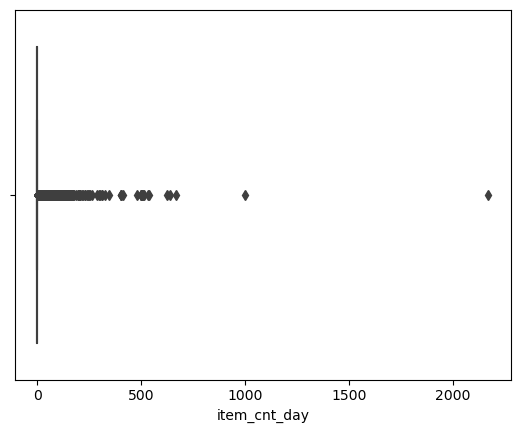

In [152]:
sns.boxplot(x=sales_train_df['item_cnt_day'])

# Записи с большими суточными продажами:
Вижно, что в данных присутствую две записи с очень высокими продажами. Данные точки можно характеризовать как выбросы

In [153]:
sales_train_df[sales_train_df['item_cnt_day'] > 900]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


Соответствующие им товары:

In [154]:
item_df[(item_df['item_id'] == 20949)|(item_df['item_id'] == 11373)]    

,item_name,item_id,item_category_id
11373,Доставка до пункта выдачи (Boxberry),11373,9
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


In [155]:
sales_train_df = sales_train_df[sales_train_df['item_cnt_day'] < 1000]

# Распределение величин item_price:

<AxesSubplot: xlabel='item_price'>

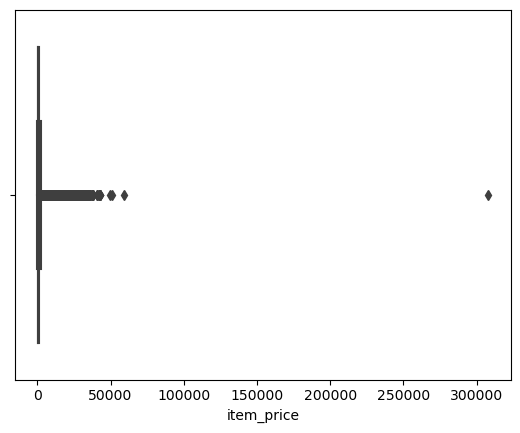

In [156]:
sns.boxplot(x=sales_train_df['item_price'])

Информация о точке выброса:

In [157]:
print('Anomaly price record:\n ', sales_train_df[sales_train_df['item_price'] > 300000],'\n')
print('Anomaly price item:\n ', item_df[item_df['item_id'] == 6066],'\n')
print('Item category:\n ', item_category_df[item_category_df['item_category_id'] == 75], '\n')

Anomaly price record:
                 date  date_block_num  shop_id  item_id  item_price  \
1163158  13.12.2013              11       12     6066    307980.0   

         item_cnt_day  
1163158           1.0   

Anomaly price item:
                   item_name  item_id  item_category_id
6066  Radmin 3  - 522 лиц.     6066                75 

Item category:
                item_category_name  item_category_id
75  Программы - Для дома и офиса                75 



Запись с отрицательной стоимостью:

In [158]:
print('Negative price record:\n ', sales_train_df[sales_train_df['item_price'] ==-1],'\n')
print('Negative price item:\n ', item_df[item_df['item_id'] == 2973],'\n')
print('Item category:\n ', item_category_df[item_category_df['item_category_id'] == 19], '\n')

Negative price record:
                date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973        -1.0           1.0 

Negative price item:
                                        item_name  item_id  item_category_id
2973  DmC Devil May Cry [PS3, русские субтитры]     2973                19 

Item category:
     item_category_name  item_category_id
19         Игры - PS3                19 



<AxesSubplot: xlabel='item_price'>

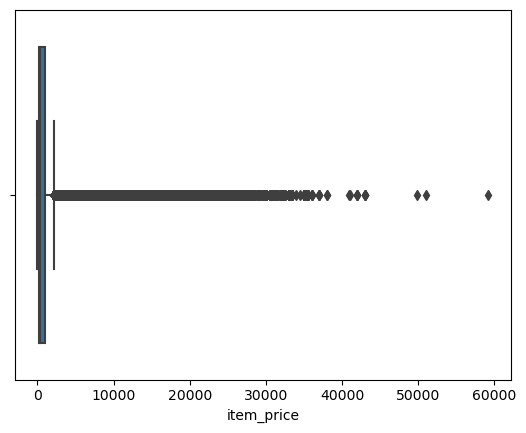

In [159]:
sales_train_df = sales_train_df[(sales_train_df['item_price'] < 300000) & (sales_train_df['item_price'] > 0)]
sns.boxplot(x=sales_train_df['item_price'])

# График продаж

In [160]:
monthly_sales = sales_train_df.groupby('date_block_num').agg({'item_cnt_day': 'sum'}).reset_index()

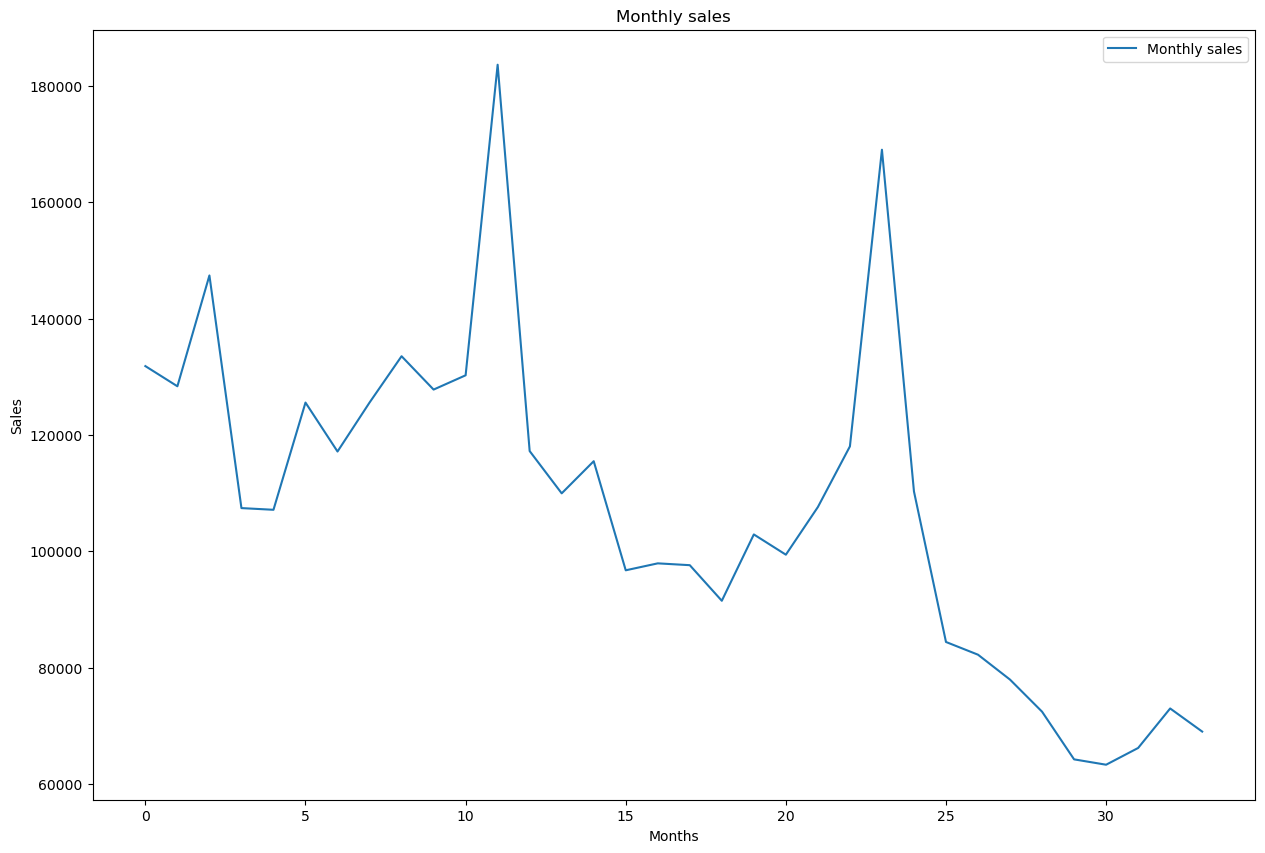

In [161]:
plt.figure(figsize=(15, 10))
plt.plot(monthly_sales['date_block_num'], monthly_sales['item_cnt_day'], label = 'Monthly sales')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.title('Monthly sales')
plt.legend()
plt.show()

Из графика видно, что среди общего тренда к снижению продаж, наблюдается так же и сезоонная компонента с частотой в 12 месяцев. Для наглядности, проведем покомпонентное разложение ряда:

C:\Users\MyPC\AppData\Local\Temp\ipykernel_1440\1327955109.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_series[0] = splited_date


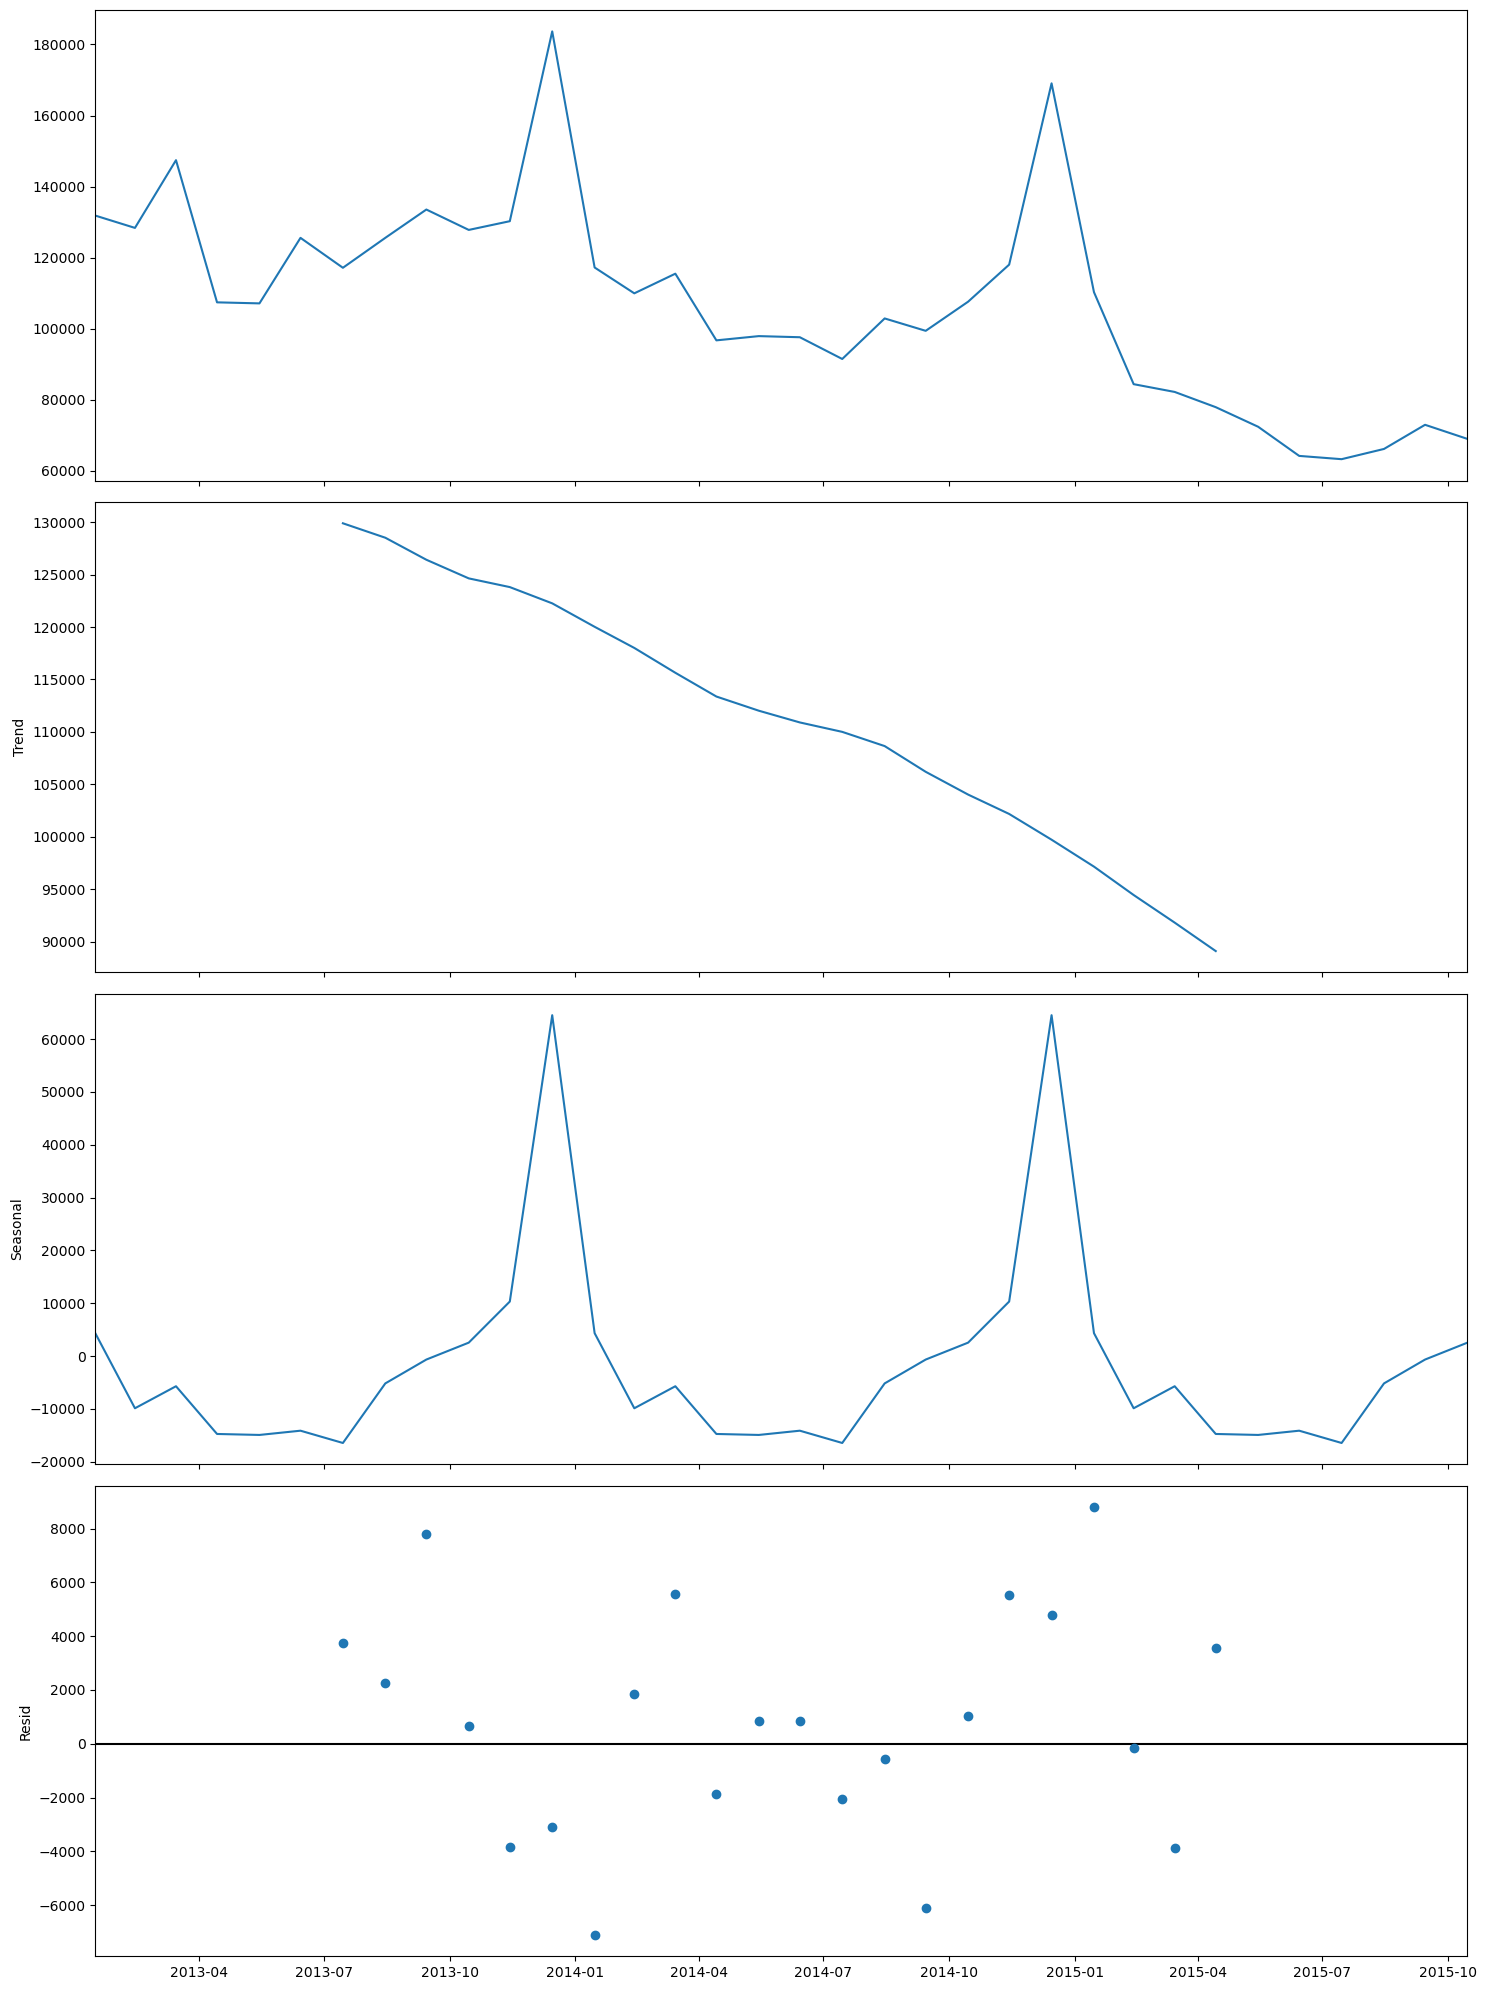

In [162]:
monthly_sales_ts = monthly_sales.copy()
monthly_sales_ts = prepare_time_series(monthly_sales_ts, 'date_block_num')

ts_decompose = seasonal_decompose(x = monthly_sales_ts, period=12)

fig = ts_decompose.plot()
fig.set_size_inches((15, 20))

fig.tight_layout()
plt.show()

In [163]:
train_df = sales_train_df.copy()
train_df = sales_train_df.merge(item_df, on='item_id', how='left')
train_df = train_df.merge(item_category_df, on='item_category_id', how='left')
train_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
3,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
4,10.01.2013,0,25,2564,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео
...,...,...,...,...,...,...,...,...,...
2928484,10.10.2015,33,25,7409,299.00,1.0,V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства
2928485,09.10.2015,33,25,7460,299.00,1.0,V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства
2928486,14.10.2015,33,25,7459,349.00,1.0,V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства
2928487,22.10.2015,33,25,7440,299.00,1.0,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3


Item_id 

In [164]:
item_sales = train_df.groupby('item_id').agg({'item_cnt_day': 'sum'}).reset_index()
item_sales

,item_id,item_cnt_day
0,0,1.0
1,1,6.0
2,2,2.0
3,3,2.0
4,4,1.0
...,...,...
21798,22165,2.0
21799,22166,348.0
21800,22167,1321.0
21801,22168,6.0


In [165]:
item_sales['item_cnt_day'].describe()

count     21803.000000
mean        167.526304
std        1360.084955
min           1.000000
25%           7.000000
50%          34.000000
75%         124.000000
max      186660.000000
Name: item_cnt_day, dtype: float64

Видно, что большинство товаров продались менее 150 раз за все время наблюдения. На фоне таких продаж, интересны те позиции товаров, которые сильно выбиваются по продажам:

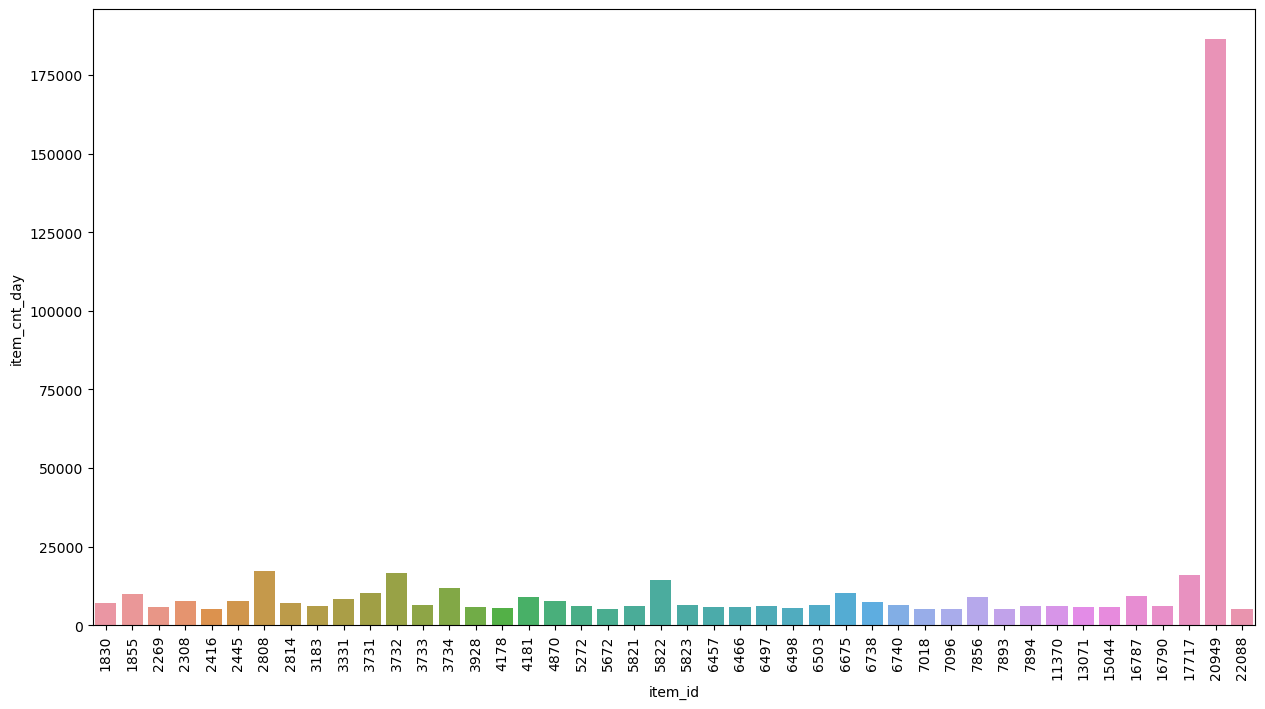

In [166]:
item_best_sales = item_sales[item_sales['item_cnt_day'] > 5000]

plt.figure(figsize=(15,8))
hist = sns.barplot(x = item_best_sales['item_id'], y = item_best_sales['item_cnt_day']).tick_params(axis='x', labelrotation=90)
plt.show()

In [167]:
item_df[item_df['item_id'] == 20949]

,item_name,item_id,item_category_id
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


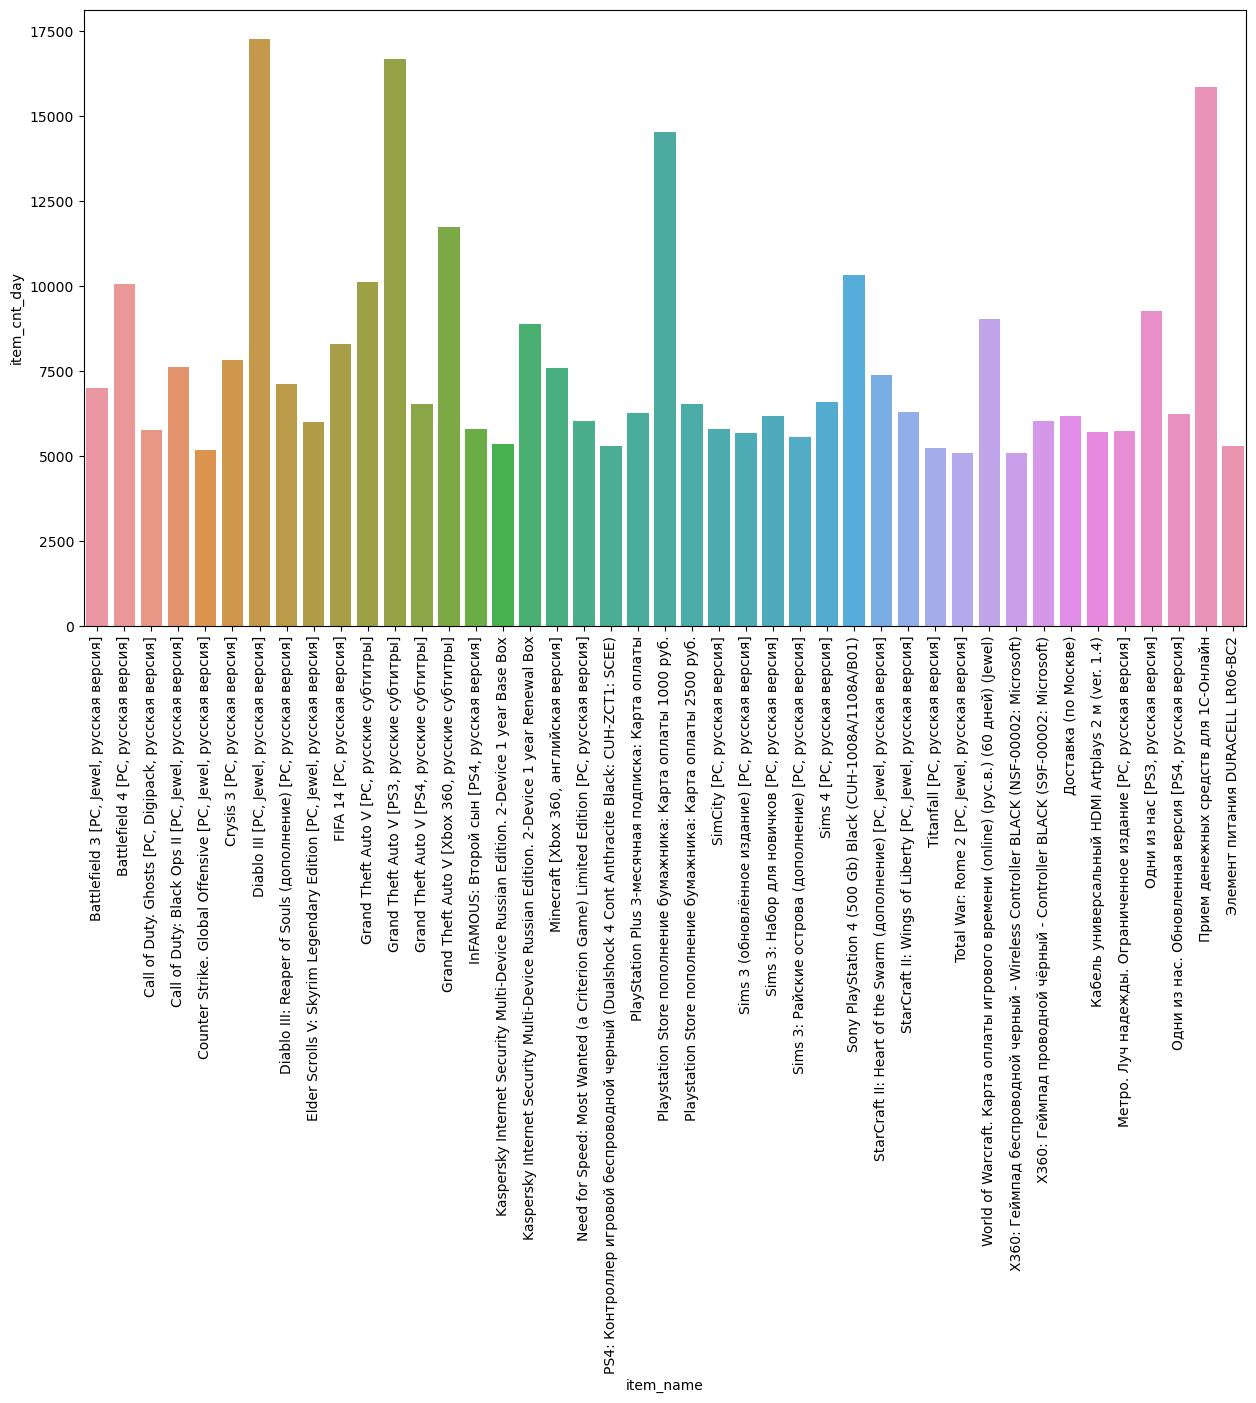

In [168]:
item_best_sales_without_bag = item_best_sales[item_best_sales['item_cnt_day'] < 186660]
item_best_sales_without_bag = item_best_sales_without_bag.merge(item_df, on='item_id', how='left')

plt.figure(figsize=(15,8))
hist = sns.barplot(x = item_best_sales_without_bag['item_name'], 
                   y = item_best_sales_without_bag['item_cnt_day']).tick_params(axis='x', labelrotation=90)
plt.show()

# Распределение продаж по катеогирям

In [169]:
category_best_sales = train_df.groupby('item_category_name').agg({'item_cnt_day': 'sum'}).reset_index()
category_best_sales

,item_category_name,item_cnt_day
0,PC - Гарнитуры/Наушники,3.0
1,Аксессуары - PS2,2.0
2,Аксессуары - PS3,19696.0
3,Аксессуары - PS4,29933.0
4,Аксессуары - PSP,2420.0
...,...,...
79,Служебные,15830.0
80,Служебные - Билеты,6137.0
81,Чистые носители (шпиль),966.0
82,Чистые носители (штучные),10437.0


In [170]:
category_best_sales = category_best_sales[category_best_sales['item_cnt_day'] > 1000]

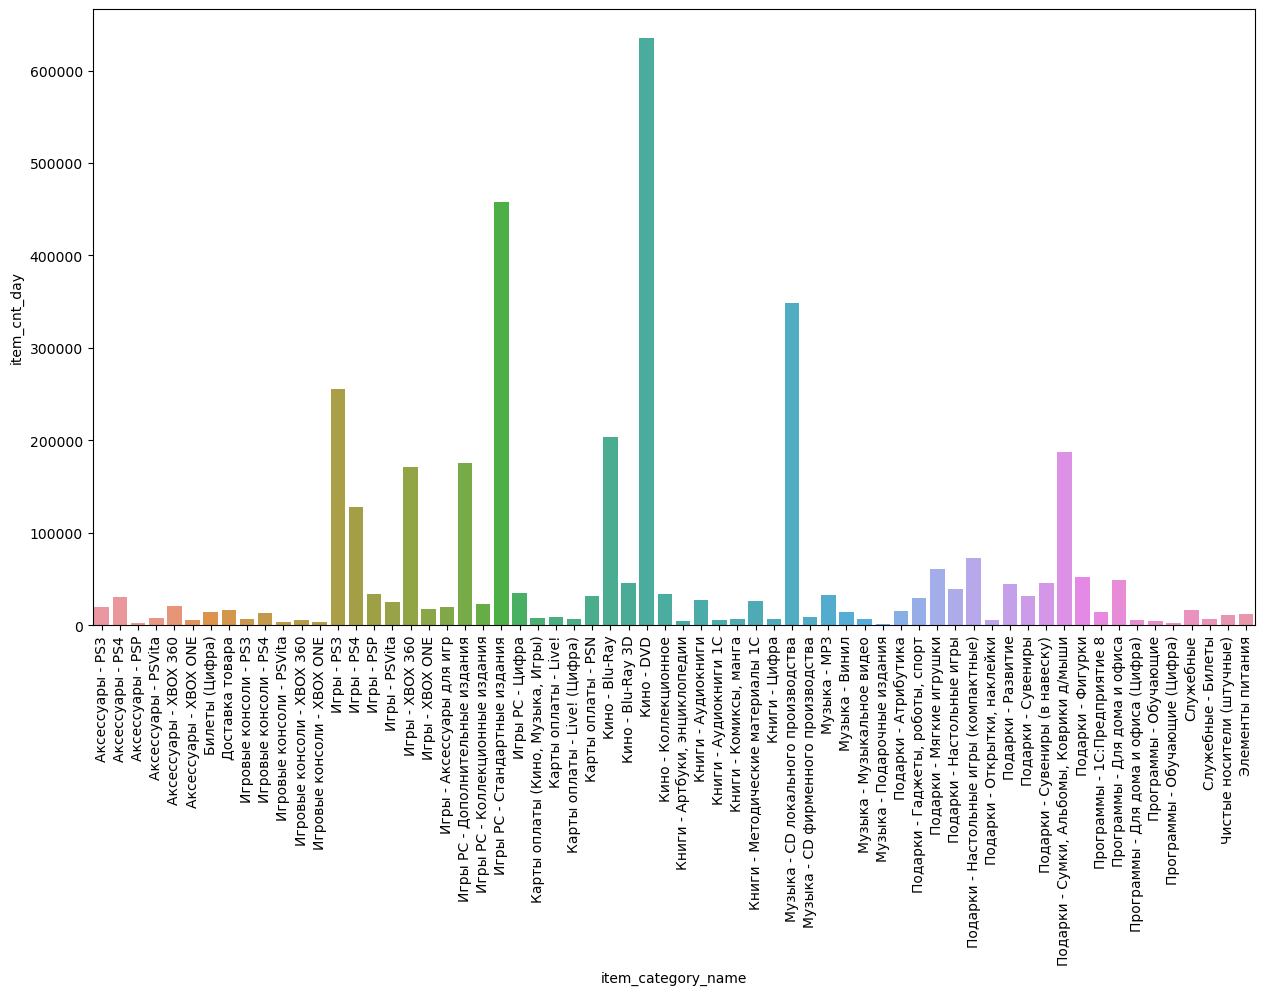

In [171]:
plt.figure(figsize=(15,8))
hist = sns.barplot(x = category_best_sales['item_category_name'],
                   y = category_best_sales['item_cnt_day']).tick_params(axis='x', labelrotation=90)
plt.show()

# Shop_df Data

In [172]:
shops_df

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


Проверим адреса магазинов на наличие дублей, при помощи векторизации каждого из адресов, а затем сравнивания косинусной близости одного вектора с другими:

In [173]:
check_records_duplicates(shops_df, 'shop_name')

0 !Якутск Орджоникидзе, 56 фран
57    Якутск Орджоникидзе, 56
Name: shop_name, dtype: object
1 !Якутск ТЦ "Центральный" фран
58    Якутск ТЦ "Центральный"
Name: shop_name, dtype: object
2 Адыгея ТЦ "Мега"
37    Новосибирск ТЦ "Мега"
Name: shop_name, dtype: object
10 Жуковский ул. Чкалова 39м?
11    Жуковский ул. Чкалова 39м²
Name: shop_name, dtype: object
14 Казань ТЦ "ПаркХаус" II
27    Москва ТЦ "МЕГА Белая Дача II"
Name: shop_name, dtype: object
16 Коломна ТЦ "Рио"
18    Красноярск ТЦ "Июнь"
50      Тюмень ТЦ "Гудвин"
Name: shop_name, dtype: object
17 Красноярск ТЦ "Взлетка Плаза"
34    Н.Новгород ТРЦ "РИО"
50      Тюмень ТЦ "Гудвин"
Name: shop_name, dtype: object
18 Красноярск ТЦ "Июнь"
50    Тюмень ТЦ "Гудвин"
Name: shop_name, dtype: object
20 Москва "Распродажа"
29    Москва ТЦ "Новый век" (Новокосино)
Name: shop_name, dtype: object
23 Москва ТК "Буденовский" (пав.А2)
24    Москва ТК "Буденовский" (пав.К7)
Name: shop_name, dtype: object
26 Москва ТЦ "Ареал" (Беляево)
30        Мо

C:\Users\MyPC\AppData\Local\Temp\ipykernel_1440\1327955109.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy[colum_name].iloc[i] = symbol_filter(df_copy[colum_name].iloc[i])


Из выписки видно, что записи - (0,57), (1,58), (10,11), (23, 24), (39,40) действительно являются дублями.

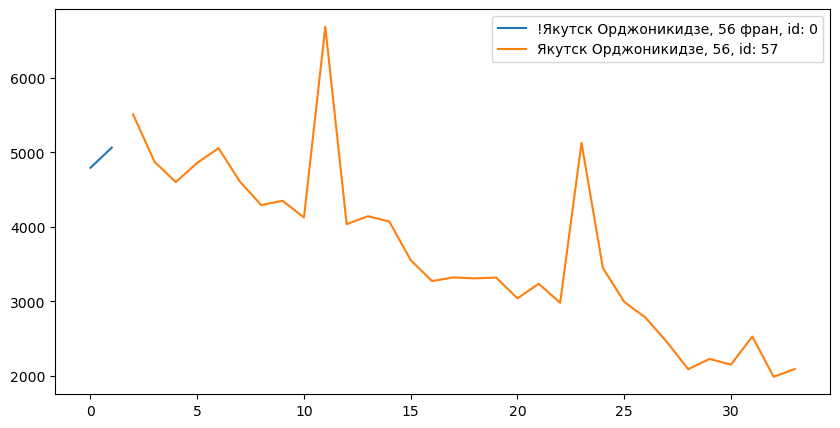

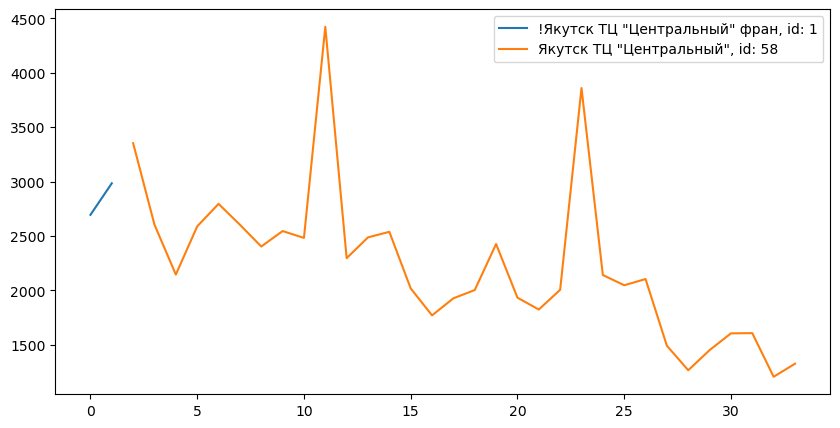

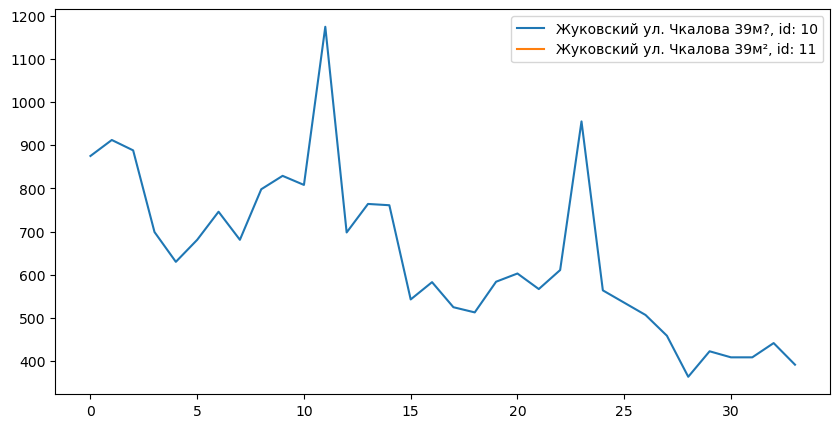

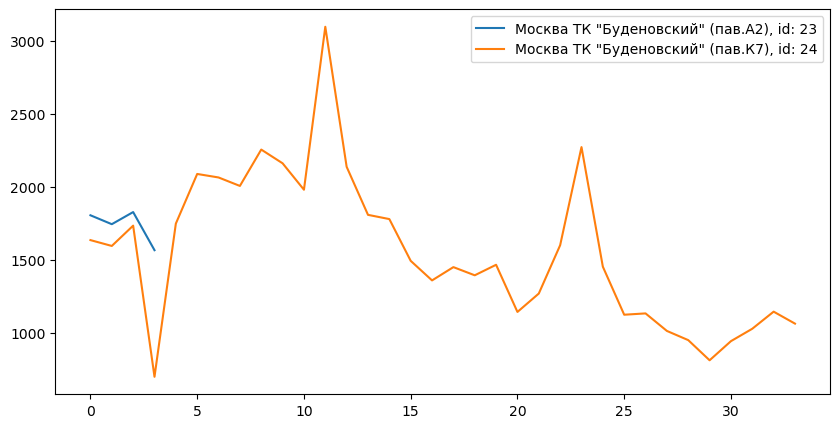

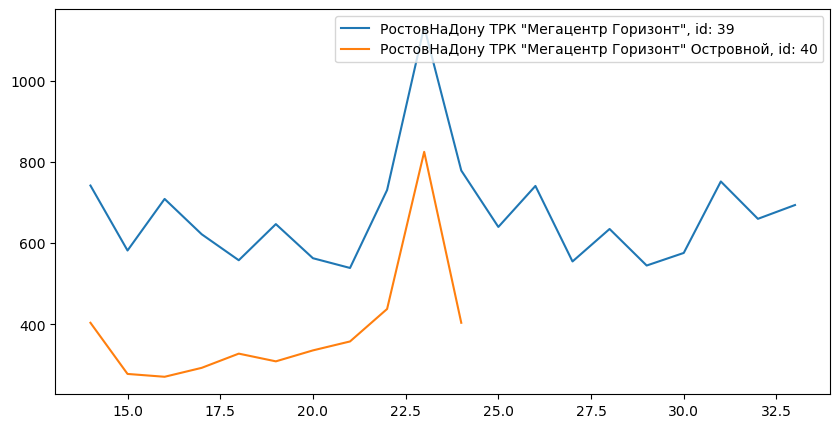

In [265]:
duplicate_list = [
    [0,57],
    [1,58],
    [10,11],
    [23,24],
    [39,40]
]

for dup in duplicate_list:
    duplicate_sales(train_df, shops_df, dup[0], dup[1])

Первые два случая с магазинами [№0 и №57] и [№1 и №58] характеризуются тем, что записи продажах в магазинах №0 и №1 регистрировались только первые два месяца, что достаточно малый срок в сравнении с периодом наблюдений.

In [176]:
print('Sum of sales records for shop № 0 until third month: ',len(train_df[(train_df['date_block_num'] <= 2) & 
                                                           (train_df['shop_id'] == 0)]))

print('Sum of sales records for shop № 0 after: ',len(train_df[(train_df['date_block_num'] > 2) & 
                                               (train_df['shop_id'] == 0)]))
print('============')

print('Sum of sales records for shop № 57 until third month: ',len(train_df[(train_df['date_block_num'] <= 2) & 
                                                            (train_df['shop_id'] == 57)]))

print('Sum of sales records for shop № 57 after: ',len(train_df[(train_df['date_block_num'] > 2) & 
                                                (train_df['shop_id'] == 57)]))

Sum of sales records for shop № 0 until third month:  9857
Sum of sales records for shop № 0 after:  0
Sum of sales records for shop № 57 until third month:  5508
Sum of sales records for shop № 57 after:  111606


In [177]:
print('Sum of sales records for shop № 1 until third month: ',len(train_df[(train_df['date_block_num'] <= 2) & 
                                                           (train_df['shop_id'] == 1)]))

print('Sum of sales records for shop № 1 after: ',len(train_df[(train_df['date_block_num'] > 2) & 
                                               (train_df['shop_id'] == 1)]))
print('============')

print('Sum of sales records for shop № 58 until third month: ',len(train_df[(train_df['date_block_num'] <= 2) & 
                                                            (train_df['shop_id'] == 58)]))

print('Sum of sales records for shop № 58 after: ',len(train_df[(train_df['date_block_num'] > 2) & 
                                                (train_df['shop_id'] == 58)]))

Sum of sales records for shop № 1 until third month:  5678
Sum of sales records for shop № 1 after:  0
Sum of sales records for shop № 58 until third month:  3352
Sum of sales records for shop № 58 after:  67916


На графике записей о продажах магазинов №10 и №11 не видно продаж №11, так как все продажи данного магазина приходятся на 25 месяц:

In [264]:
train_df[(train_df['shop_id'] == 11)]['date_block_num'].unique()

array([25], dtype=int64)

Данные обстоятельства говорят о корреляции с продажами магазина №10, посколько у него в этот день продаж не наблюдалось вовсе:

In [266]:
print('Sum of sales records for shop № 10 in 25 mounth: ',len(train_df[(train_df['date_block_num'] == 25) & 
                                                                       (train_df['shop_id'] == 10)]))

print('Sum of sales records for shop № 11 in 25 mounth: ',len(train_df[(train_df['date_block_num'] == 25) & 
                                                                       (train_df['shop_id'] == 11)]))

Sum of sales records for shop № 10 in 25 mounth:  0
Sum of sales records for shop № 11 in 25 mounth:  499


Ситуация с магазинами №23 и №24 аналогична ситуации в первых двух случаях: записи о продажах магазина №23 наблюдаются только первые 3 месяца, что является сравнительно малым промежутком времени относительно периода наблюдений:

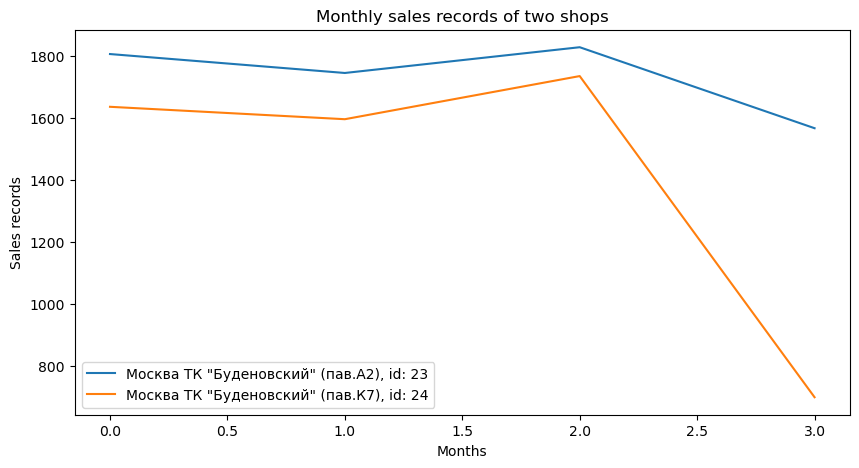

Sum of sales records for shop shop № 23 first 3 months:  6946
Sum of sales records for shop shop № 23 after:  0


In [179]:
duplicate_sales(train_df[train_df['date_block_num'] < 4], shops_df, 23, 24)
print('Sum of sales records for shop shop № 23 first 3 months: ',len(train_df[(train_df['date_block_num'] <= 3) & 
                                                                              (train_df['shop_id'] == 23)]))

print('Sum of sales records for shop shop № 23 after: ',len(train_df[(train_df['date_block_num'] > 3) & 
                                                (train_df['shop_id'] == 23)]))

В случае магазинов №39 и №40 продажи фиксировались в обоих магазинах на протяжении 10 месяцев, что является продолжительным периодом. Единственный довод в пользу того, что эти два магазина могут быть дублями заключается в том, что на графике магазина №39 не наблюдается тенденции к снижению продаж, которая наблюдается в остальных случаях. При суммировании записей о продажах двух магазинов, тенденция к снижению начинает проявлятся:

In [270]:
monthly_sales_shop_39 = sales_train_df[sales_train_df['shop_id'] == 39].groupby('date_block_num').agg({'item_cnt_day': 'sum'}).reset_index()
united_sales_of_two_shops = sales_train_df[(sales_train_df['shop_id'] == 39) |
                                           (sales_train_df['shop_id'] == 40)
                                          ].groupby('date_block_num').agg({'item_cnt_day': 'sum'}).reset_index()

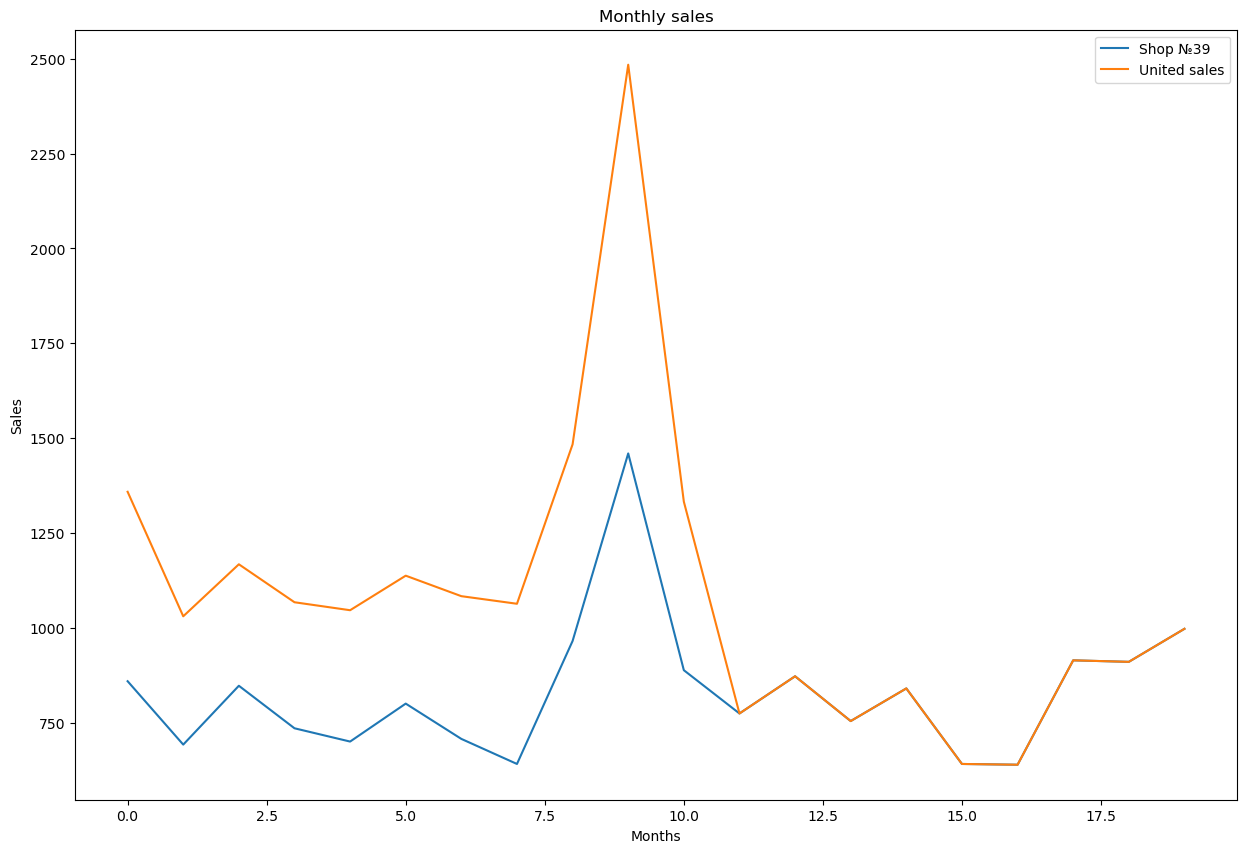

In [271]:
plt.figure(figsize=(15, 10))
plt.plot(monthly_sales_shop_39['item_cnt_day'], label = 'Shop №39')
plt.plot(united_sales_of_two_shops['item_cnt_day'], label = 'United sales')

plt.xlabel('Months')
plt.ylabel('Sales')
plt.title('Monthly sales')
plt.legend()
plt.show()

Итого, записи о магазинах изменяться следующим образом:
0 -> 57
1 -> 58
11 -> 10
23 -> 24
40 -> 39

In [286]:
duplicate_list = [
    [0,57],
    [1,58],
    [11,10],
    [23,24],
    [40,41]
]

for pair in duplicate_list:
    sales_train_df['shop_id'][sales_train_df['shop_id'] == pair[0]] = pair[1]

C:\Users\MyPC\AppData\Local\Temp\ipykernel_1440\3318225910.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_train_df['shop_id'][sales_train_df['shop_id'] == pair[0]] = pair[1]
C:\Users\MyPC\AppData\Local\Temp\ipykernel_1440\3318225910.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_train_df['shop_id'][sales_train_df['shop_id'] == pair[0]] = pair[1]
C:\Users\MyPC\AppData\Local\Temp\ipykernel_1440\3318225910.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

Распределение продаж по магазинам:

In [287]:
uniq_shopping = monthly_sales = sales_train_df.groupby('shop_id').agg({'item_cnt_day': 'sum'}).reset_index()

<function matplotlib.pyplot.show(close=None, block=None)>

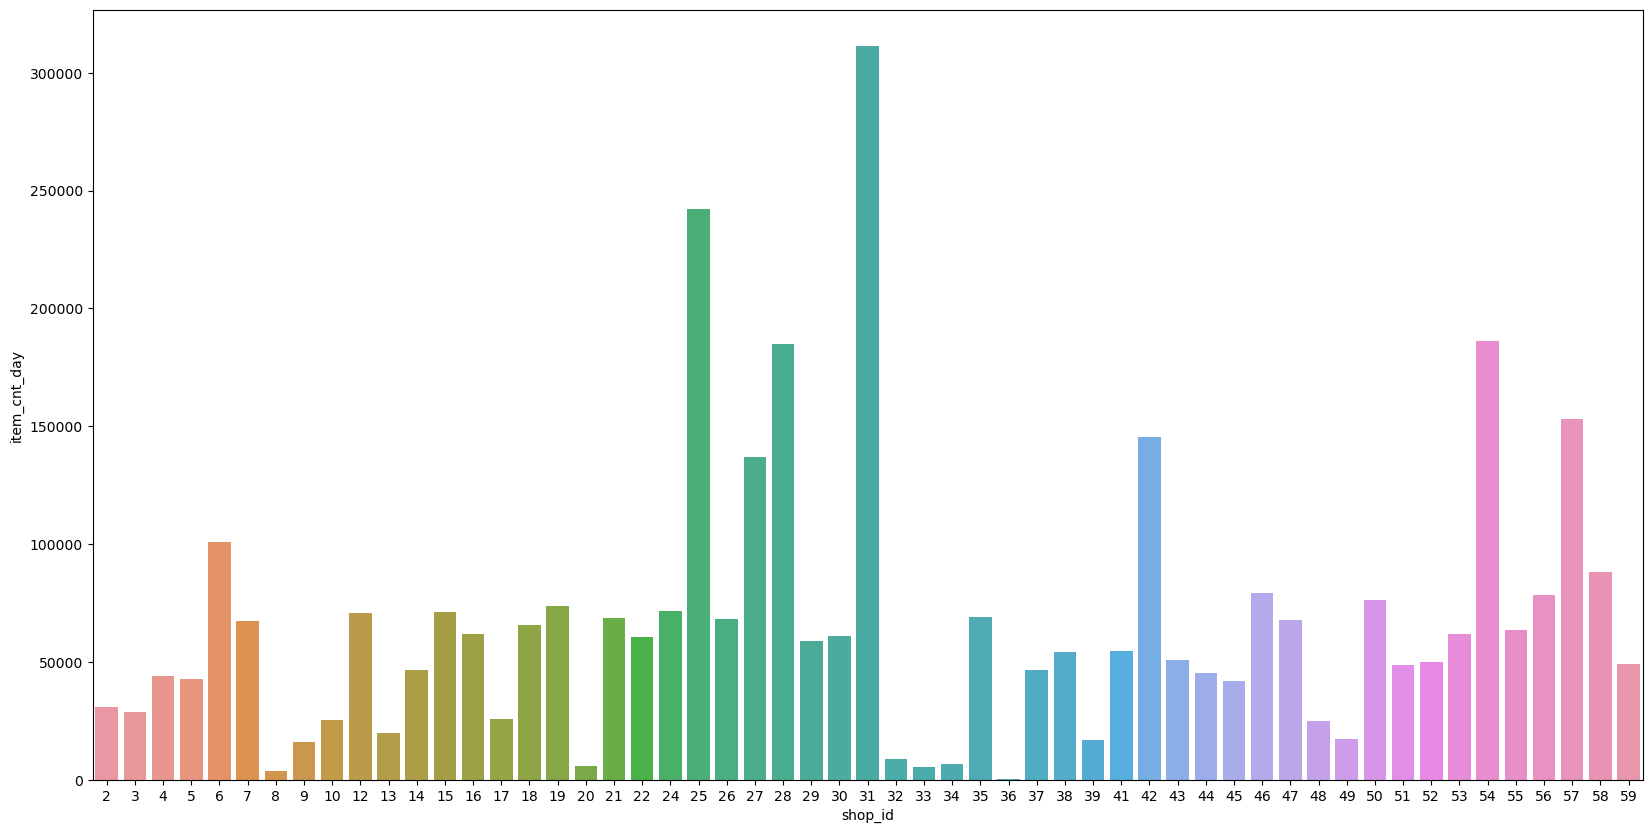

In [288]:
plt.figure(figsize=(20,10))
hist = sns.barplot(x = uniq_shopping['shop_id'], y = uniq_shopping['item_cnt_day'])
plt.show  

In [309]:
#item_test = item_df[:150]
item_category_df

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [310]:
check_records_duplicates(item_category_df, 'item_category_name')

C:\Users\MyPC\AppData\Local\Temp\ipykernel_1440\514135807.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy[colum_name].iloc[i] = symbol_filter(df_copy[colum_name].iloc[i])
100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 492.83it/s]


3 Аксессуары - PS4
7    Аксессуары - XBOX ONE
Name: item_category_name, dtype: object
10 Игровые консоли - PS2
12    Игровые консоли - PS4
Name: item_category_name, dtype: object
11 Игровые консоли - PS3
12    Игровые консоли - PS4
Name: item_category_name, dtype: object
12 Игровые консоли - PS4
13         Игровые консоли - PSP
14      Игровые консоли - PSVita
16    Игровые консоли - XBOX ONE
17      Игровые консоли - Прочие
Name: item_category_name, dtype: object
14 Игровые консоли - PSVita
16    Игровые консоли - XBOX ONE
Name: item_category_name, dtype: object
15 Игровые консоли - XBOX 360
16    Игровые консоли - XBOX ONE
Name: item_category_name, dtype: object
20 Игры - PS4
24    Игры - XBOX ONE
Name: item_category_name, dtype: object
28 Игры PC - Дополнительные издания
29    Игры PC - Коллекционные издания
30      Игры PC - Стандартные издания
Name: item_category_name, dtype: object
29 Игры PC - Коллекционные издания
30    Игры PC - Стандартные издания
Name: item_category_name, dt